In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from scipy.interpolate import griddata

In [2]:
df = pd.read_excel('Enhanced_Misaghi.xls')
print(df.head())

      DHID            X            Y          Z  From   To  Length     Au  \
0  B202-01  588916.5036  3920681.738  1576.0343   0.0  2.0     2.0  3.540   
1  B202-01  588916.5036  3920681.738  1576.0343   2.0  4.0     2.0  0.156   
2  B202-02  588912.8198  3920681.310  1576.1292   0.0  2.0     2.0  0.144   
3  B202-02  588912.8198  3920681.310  1576.1292   2.0  4.0     2.0  0.096   
4  B202-03  588910.1704  3920681.063  1575.9898   0.0  2.0     2.0  0.060   

       CuT         Region  
0  0.04116  Medium Copper  
1  0.05880  Medium Copper  
2  0.05880    Medium Gold  
3  0.07644    Medium Gold  
4  0.16072    Medium Gold  


In [3]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a strategy (mean, median, etc.)
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the features (CuT and Au)
df[['CuT', 'Au']] = imputer.fit_transform(df[['CuT', 'Au']])

In [4]:
X = df[['CuT', 'Au']]
y = df['Region']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
model = VotingClassifier([
    ('DT', DecisionTreeClassifier(max_depth=3)),
    ('SVC', SVC(C=100, kernel='rbf', probability=True)),
    ('LR', LogisticRegression())
], voting='soft')

model.fit(X_train, y_train)

VotingClassifier(estimators=[('DT', DecisionTreeClassifier(max_depth=3)),
                             ('SVC', SVC(C=100, probability=True)),
                             ('LR', LogisticRegression())],
                 voting='soft')

In [7]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9267399267399268

Classification Report:
                precision    recall  f1-score   support

   High Grade       0.96      1.00      0.98        75
    Low Grade       1.00      1.00      1.00        63
Medium Copper       0.97      0.84      0.90        43
  Medium Gold       0.82      1.00      0.90        74
        Mixed       1.00      0.28      0.43        18

     accuracy                           0.93       273
    macro avg       0.95      0.82      0.84       273
 weighted avg       0.94      0.93      0.92       273



In [8]:
# Store predictions in the DataFrame
df['Predicted_Region'] = model.predict(X)

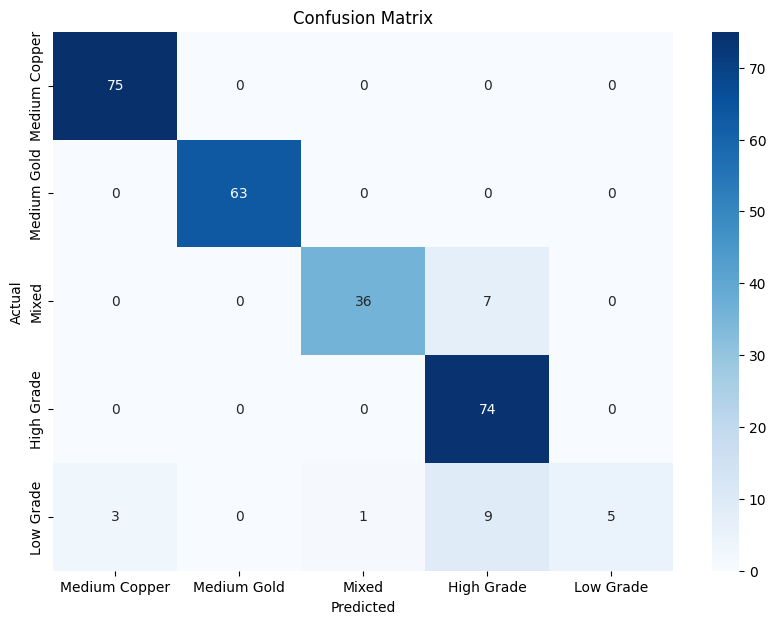

In [9]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
unique_regions = df['Region'].unique()

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_regions, yticklabels=unique_regions)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


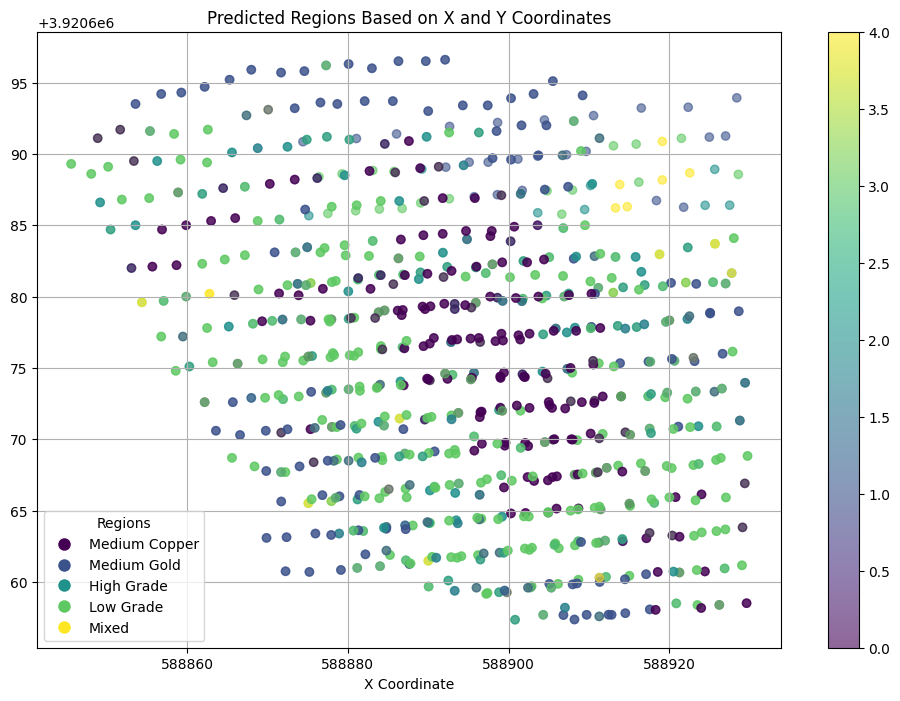

In [10]:
# Assuming 'X' and 'Y' are columns in your DataFrame representing coordinates
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['X'], df['Y'], c=df['Predicted_Region'].astype('category').cat.codes,
                      cmap='viridis', alpha=0.6)

# Adding labels and title
plt.title('Predicted Regions Based on X and Y Coordinates')
plt.xlabel('X Coordinate')
# Create a legend with region names based on unique categories in predicted regions
unique_regions = df['Predicted_Region'].unique()  # Get unique region names
handles = [plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) for i in range(len(unique_regions))]
legend_labels = unique_regions.tolist()

# Create the legend using the actual region names
plt.legend(handles, legend_labels, title="Regions")
plt.colorbar(scatter)
plt.grid()
plt.show()

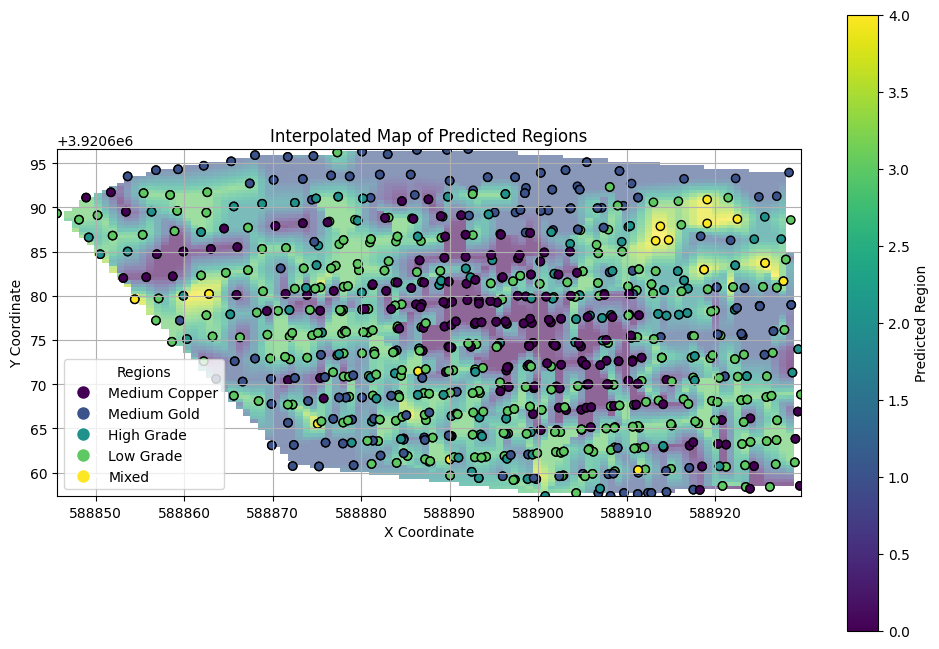

In [11]:
# Define grid for interpolation
grid_x, grid_y = np.mgrid[df['X'].min():df['X'].max():100j, df['Y'].min():df['Y'].max():100j]

# Interpolate the predicted regions
grid_z = griddata((df['X'], df['Y']), df['Predicted_Region'].astype('category').cat.codes, (grid_x, grid_y), method='linear')

# Plot the interpolated map
plt.figure(figsize=(12, 8))
plt.imshow(grid_z.T, extent=(df['X'].min(), df['X'].max(), df['Y'].min(), df['Y'].max()), origin='lower', cmap='viridis', alpha=0.6)
scatter = plt.scatter(df['X'], df['Y'], c=df['Predicted_Region'].astype('category').cat.codes, cmap='viridis', edgecolor='k')
plt.title('Interpolated Map of Predicted Regions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.colorbar(label='Predicted Region')
plt.grid()

# Create a legend with region names based on unique categories in predicted regions
unique_regions = df['Predicted_Region'].unique()  # Get unique region names
handles = [plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) for i in range(len(unique_regions))]
legend_labels = unique_regions.tolist()

# Create the legend using the actual region names
plt.legend(handles, legend_labels, title="Regions")
plt.show()


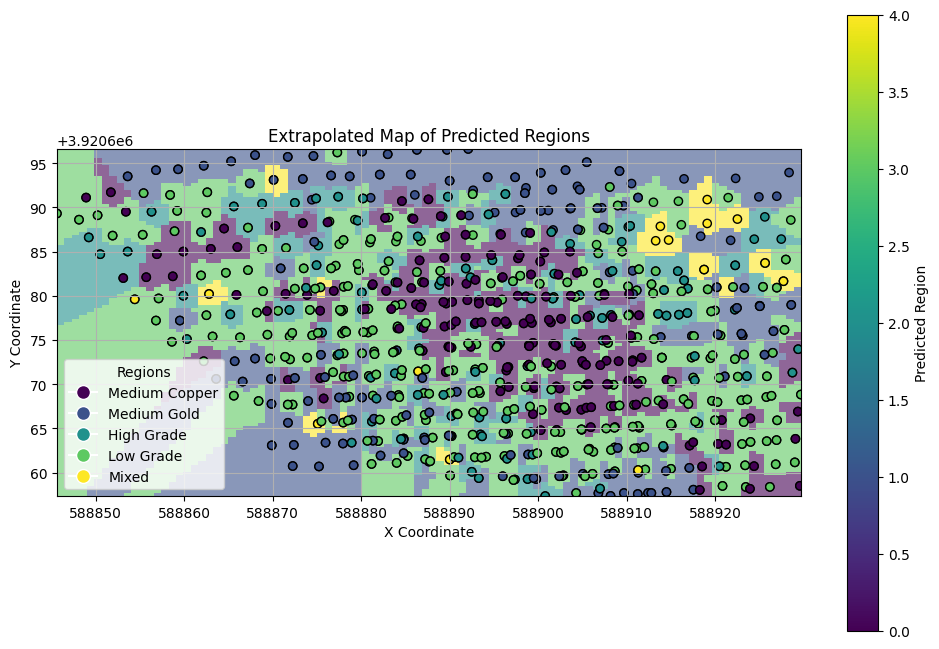

In [14]:
# Define grid for interpolation
grid_x, grid_y = np.mgrid[df['X'].min():df['X'].max():100j, df['Y'].min():df['Y'].max():100j]

# Interpolate the predicted regions with extrapolation
grid_z = griddata((df['X'], df['Y']), df['Predicted_Region'].astype('category').cat.codes, (grid_x, grid_y), method='nearest')

# Plot the interpolated map
plt.figure(figsize=(12, 8))
plt.imshow(grid_z.T, extent=(df['X'].min(), df['X'].max(), df['Y'].min(), df['Y'].max()), origin='lower', cmap='viridis', alpha=0.6)
scatter = plt.scatter(df['X'], df['Y'], c=df['Predicted_Region'].astype('category').cat.codes, cmap='viridis', edgecolor='k')
plt.title('Extrapolated Map of Predicted Regions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.colorbar(label='Predicted Region')
plt.grid()

# Create a legend with region names based on unique categories in predicted regions
unique_regions = df['Predicted_Region'].unique()  # Get unique region names
handles = [plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) for i in range(len(unique_regions))]
legend_labels = unique_regions.tolist()

# Create the legend using the actual region names
plt.legend(handles, legend_labels, title="Regions")
plt.show()
